# import and install library

In [1]:
import pandas as pd
import numpy as np

from google.colab import output
!pip install hazm
!pip install arabic-reshaper
!pip install python-bidi
!pip install persian_wordcloud
!pip install langdetect
!pip install mapply



import hazm
from hazm import *
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
from arabic_reshaper import reshape
from bidi.algorithm import get_display
from langdetect import detect, LangDetectException
import mapply
import glob
from wordcloud import WordCloud
from hazm import stopwords_list
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')


output.clear()

# Initialization

1. **Parallel Processing Setup:**  
   - `mapply.init(...)` initializes a parallel processing framework with multiple workers (`n_workers=-1` uses all available processors), processing data in chunks (`chunk_size=100` and `max_chunks_per_worker=8`), with a visible progress bar.

2. **Text Cleaning Components:**  
   - **Punctuations:**  
     - Combines English (`string.punctuation`) and Persian punctuation symbols (`persian_punctuations`) into a single list for later removal.
   - **Diacritics:**  
     - Compiles a regex (`arabic_diacritics`) to remove common Arabic diacritics (e.g., Tashdid, Fatha, etc.).
   - **Lemmatization and Normalization:**  
     - Initializes `hazm.Lemmatizer()` for lemmatizing Persian words.  
     - Initializes a `Normalizer()` to standardize text.

3. **Font Setup:**  
   - Specifies a Persian font path (`font_path`) for visualizations like word clouds.

4. **Stopwords Loading:**  
   - Uses `glob` to find all text files with Persian stopwords in a specific folder.
   - Reads each file and compiles a master list of stopwords.
   - Removes newline characters from each stopword.
   - Extends the list with additional stopwords from `stopwords_list()` from hazm.



This setup prepares your environment to clean, normalize, and process Persian text data efficiently in a parallelized manner.

In [2]:
mapply.init(
    n_workers=-1,
    chunk_size=100,
    max_chunks_per_worker=8,
    progressbar=True,
)

persian_punctuations = '''`÷×؛#<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
punctuations_list = string.punctuation + persian_punctuations
arabic_diacritics = re.compile("""
                          ّ    | # Tashdid
                          َ    | # Fatha
                          ً    | # Tanwin Fath
                          ُ    | # Damma
                          ٌ    | # Tanwin Damm
                          ِ    | # Kasra
                          ٍ    | # Tanwin Kasr
                          ْ    | # Sukun
                          ـ     # Tatwil/Kashida
                      """, re.VERBOSE)
lemmatizer = hazm.Lemmatizer()
normalizer = Normalizer()

font_path = "/content/drive/MyDrive/Gandom.ttf"



file_list = glob.glob('/content/drive/MyDrive/NLP/persian_stopwords' + '/*.txt')

stop_words = []

for file_path in file_list:
    with open(file_path) as f:
        stop_words.extend(f.readlines())

for i in range(len(stop_words)):
    stop_words[i]=stop_words[i].replace('\n','')

stop_words.extend(stopwords_list())
output.clear()

# read and see 5 first row of data sets

In [3]:
df = pd.read_csv("/content/drive/MyDrive/get news/farsnews/farsnews_fainal.csv")
df.head(5)

,Unnamed: 0,title,text,date,label
0,1,قارایی: در تلاشم تا سیاه نمایی درباره ایران با...,خبرگزاری فارس - گروه هنر و رسانه - علی عبدالهی...,۰۹:۳۹ - ۱۴۰۲-۳-۶,culture-media
1,2,توجه ویژه به اقوام و چهره های مردمی در فصل جدی...,به گزارش خبرگزاری فارس، پویان هدایتی، تهیه کن...,۰۹:۳۹ - ۱۴۰۲-۳-۶,culture-media
2,3,جان فدا| ویژه برنامه هاى تلویزیون در سومین سال...,به گزارش خبرنگار رادیو و تلویزیون خبرگزاری فار...,۰۹:۳۹ - ۱۴۰۲-۳-۶,culture-media
3,4,محمد علی صائب رئیس خبرگزاری صدا وسیما شد,به گزارش خبرگزاری فارس، علیرضا خدابخشی، معاون ...,۰۹:۳۹ - ۱۴۰۲-۳-۶,culture-media
4,5,«همراه با خاطره ها» تمدید شد,به گزارش خبرگزاری فارس به نقل از روابط عمومی و...,۰۹:۳۹ - ۱۴۰۲-۳-۶,culture-media


# shape of data set

In [4]:
df.shape

(64944, 5)

# drop columns

- The columns of Unnamed: 0 and date are useless.

In [5]:
df = df.drop(['Unnamed: 0', 'date'], axis=1)

- info of data sets

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64944 entries, 0 to 64943
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   64944 non-null  object
 1   text    64942 non-null  object
 2   label   64944 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB


In [7]:
df.isnull().sum()

,0
title,0
text,2
label,0


# How much is each label?

In [8]:
label_counts = df["label"].value_counts().reset_index()
label_counts.columns = ["label", "count"]
label_counts

,label,count
0,sports,21397
1,social,12802
2,culture-media,11324
3,economy,10163
4,politics,9258


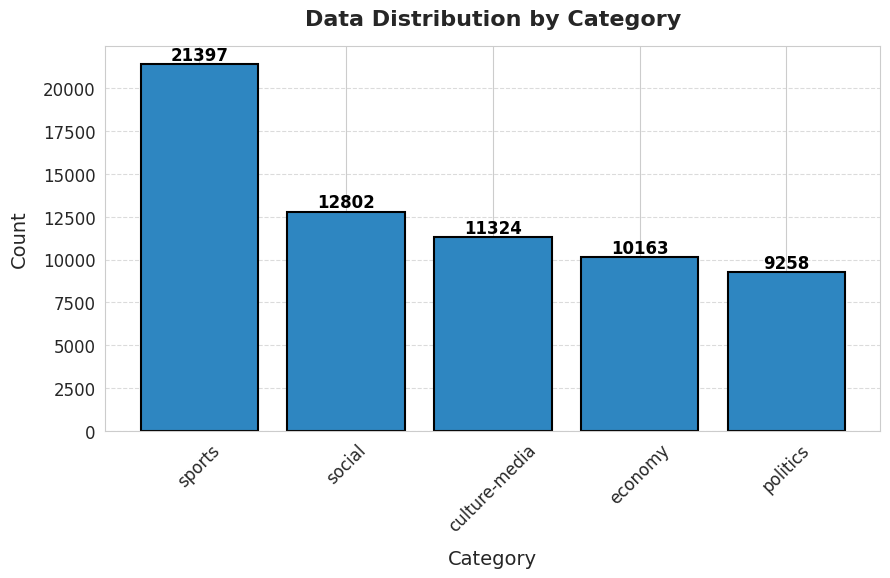

In [9]:
# Set a modern style
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(10, 5))  # Adjust figure size
bars = plt.bar(label_counts["label"], height=label_counts["count"], color="#2E86C1", edgecolor="black", linewidth=1.5)

# Customize labels and title
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels
plt.yticks(fontsize=12)
plt.xlabel("Category", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)
plt.title("Data Distribution by Category", fontsize=16, fontweight="bold", pad=15)

# Add grid lines
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add value annotations on bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             str(int(bar.get_height())),
             ha='center', va='bottom', fontsize=12, fontweight="bold", color="black")

# Show the plot
plt.show()


# preprocessing :

1. **Initialization (`__init__`)**  
   - Defines Persian and English punctuation marks.  
   - Compiles a regex pattern to remove Arabic diacritics (Tashdid, Fatha, Damma, etc.).  
   - Loads Persian stopwords (`stop_words`) and a lemmatizer (`hazm.Lemmatizer()`).

2. **Text Cleaning Methods:**  
   - `_remove_diacritics(text)`: Removes Arabic diacritics.  
   - `_remove_crash_data(text)`: Ensures input is a string.  
   - `_remove_punctuations(text)`: Removes punctuation marks.  
   - `_remove_repeating_char(text)`: Replaces repeating characters (e.g., "سلاااام" → "سلام").  

3. **Normalization & Tokenization:**  
   - `_normalize_persian(text)`: Converts Arabic letters to Persian equivalents, removes non-Persian characters, and normalizes text.  
   - `_tokenize(text)`: Splits text into words.  

4. **Stopwords & Lemmatization:**  
   - `_remove_stopwords(words)`: Removes common Persian stopwords and short words.  
   - `_lemmatizer(words)`: Lemmatizes words and removes stopwords again.  


In [10]:
class preprocessing:
  def __init__(self):
    persian_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    self.punctuations_list = string.punctuation + persian_punctuations
    self.arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    self.stop_words = stop_words
    self.lemmatizer = hazm.Lemmatizer()

  def _remove_diacritics(self, text):
    text = re.sub(self.arabic_diacritics, '', text)
    return text


  def _remove_crash_data(self, text):
    if isinstance(text, str):
      return text
    else:
      return None

  def _remove_punctuations(self, text):
    translator = str.maketrans('', '', self.punctuations_list)
    return text.translate(translator)

  def _remove_repeating_char(self, text):
    return re.sub(r'(.)\1+', r'\1', text)


  def _normalize_persian(self, text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ي", "ی", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ی", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("ك" ,"ک" , text)
    text = re.sub("[^ابپتثجچحخدذرزژسشصضطظعغفقکگلمنوهی]", " ", text)
    text = re.sub("[^\S\n\t]+", ' ', text)
    text = normalizer.normalize(text)
    return text


  def _tokenize(self, text):
    return text.split()

  def _remove_stopwords(self, words):
    return [word  for word in words if word not in self.stop_words and len(word) > 2]

  def _lemmatizer(self, words):
    result = list()
    for token in words:
      result.append(self.lemmatizer.lemmatize(token))
    return self._remove_stopwords(result)

In [11]:
pp = preprocessing()
df['title - preproces'] = df['title'].mapply(pp._remove_diacritics)
df['title - preproces'] = df['title - preproces'].mapply(pp._remove_punctuations)
df['title - preproces'] = df['title - preproces'].mapply(pp._remove_repeating_char)
df['title - preproces'] = df['title - preproces'].mapply(pp._normalize_persian)
df['title - preproces'] = df['title - preproces'].mapply(pp._tokenize)
df['title - preproces'] = df['title - preproces'].mapply(pp._remove_stopwords)
df['title - preproces'] = df['title - preproces'].mapply(pp._lemmatizer)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

# wordcloud

This code generates a **word cloud** from preprocessed text data in a Pandas DataFrame (`df`). Here's a breakdown of the steps:

1. **Prepare Text Data**  
   - `df['title - preproces']` contains tokenized text (lists of words).  
   - The lambda function joins tokens into a single string for each row.  
   - All processed titles are concatenated into `text`.

2. **Create a Word Cloud**  
   - `WordCloud()` is initialized with:  
     - White background.  
     - Custom Persian font (`font_path`).  
     - Stopwords list (`stop_words`) to remove common words.  
     - Adjusted `width`, `height`, `max_words`, and `max_font_size`.  
     - `scale=5` for high resolution.  
   - `.generate(text)` processes the text to create the word cloud.

3. **Display the Word Cloud**  
   - `plt.imshow(wordcloud, interpolation='bilinear')` renders the word cloud.  
   - `plt.axis("off")` hides axis labels.  
   - `plt.title()` adds a title with styling.  
   - `plt.show()` displays the visualization.  


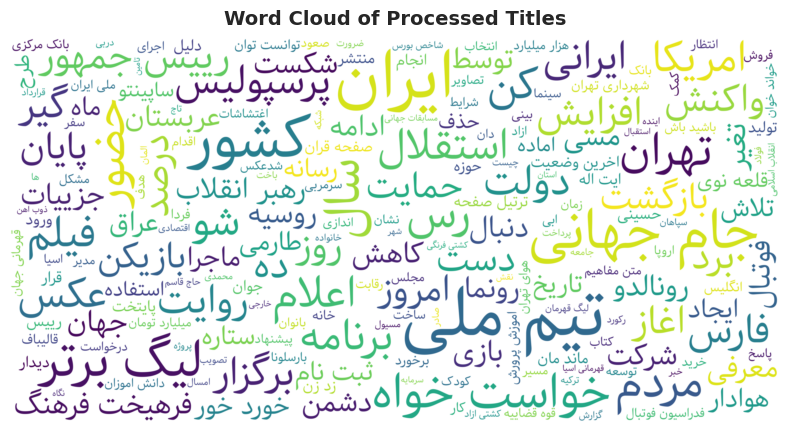

In [12]:
sents = df['title - preproces'].apply(lambda tokens : " ".join([token for token in tokens]))

text = " ".join(sents)

# Generate the word cloud
wordcloud = WordCloud(
    background_color='white',
    font_path=font_path,
    stopwords=stop_words,
    width=800,
    height=400,
    max_words=200,
    max_font_size=70,
    scale=5
).generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hides axis labels
plt.title("Word Cloud of Processed Titles", fontsize=14, fontweight="bold", pad=10)
plt.show()